# Benefit of MR-guided online adaptive radiation therapy in the treatment of oligometastatic hepatic malignancies - Analysis

Michael Mayinger, Roman Ludwig, Sebastian Christ, Alex Ryue, Nienke Weidkamp, Riccardo DalBello, Jan Unkelbach, Matthias Guckenberger, Stephanie Tanadini-Lang, Nicolaus Andratschke 

Department of Radiation Oncology, University Hospital of Zurich, University of Zurich, Zurich, Switzerland

***

This jupyter notebook contains most of our analysis done for the mentioned paper.

## Imports

In [1]:
import numpy as np     # numerical package for vectors, matrices, algebra and everything. Super useful!
import scipy as sp     # scientific package with all sorts of functionalities, including...
import scipy.stats     # ...statistical methods (probability distributions, statistical tests, ...)
import matplotlib
import matplotlib.pyplot as plt  # a vast plotting library
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import itertools
from pathlib import Path   # handy tool for resolving paths on the disks
import pandas as pd        # powerful package that brings excel-like capabilities to python

## Settings

In [2]:
load_path = Path("./data").resolve()    
plot_path = Path("./plots").resolve()

matplotlib.rcParams["figure.dpi"] = 300

letters = np.asarray([f"${c}$" for c in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"])
numbers = np.asarray([f"${i}$" for i in range(1,20)])
markers = np.asarray(['o', 'v', '^', '<', '>', 's', 'p', 'D', 'X', 'h'])
letters_cycle = itertools.cycle(letters)
numbers_cycle = itertools.cycle(numbers)
markers_cycle = itertools.cycle(markers)

tab20 = cm.get_cmap("tab20")   # here I acces a colormap

usz_blue = '#005ea8'
usz_green = '#00afa5'
usz_red = '#ae0060'
usz_orange = '#f17900'
usz_gray = '#c5d5db'

## Loading data
Tables of metrics for various structures of both conventional and adaptive fractions for all fifteen patients.

In [3]:
data = pd.read_csv(load_path/"data.csv")
conformity_index = pd.read_csv(load_path/"conformity_index.csv")
distances = pd.read_csv(load_path/"distances.csv")

## Analysis

### Helper function

Helper function that - for a given metric & structure - returns the conventional values as `x`, the adapted ones as `y` and also a list of patient numbers `c`. The idea behind the patient numbers is the following: If `c[11] == 5` that means that the 12th entry (Python starts counting from 0) in the arrays `x` and `y` comes from patient number 5.

This will used for assigning color and symbols to the individual patients in the plots.

In [4]:
def con_vs_art(data, structure, metric):
    # when a "D" is in the metric (as in "DMEAN"), the output is an absolute dose that 
    # needs to be divided by the number of delivered fractions
    if "D" in metric:
        div = data.loc[(data["type"]=="adapted") \
                       & (data["structure"]==structure) \
                       & (data["metric"]==metric), "fraction_num"].to_numpy()
    else:
        div = 1.
        
    x = data.loc[(data["structure"]==structure) & 
                 (data["metric"]==metric) & 
                 (data["type"]=="conventional"), 
                 "value"].to_numpy() / div
    y = data.loc[(data["structure"]==structure) & 
                 (data["metric"]==metric) & 
                 (data["type"]=="adapted"), 
                 "value"].to_numpy() / div
    c = data.loc[(data["structure"]==structure) & 
                 (data["metric"]==metric) & 
                 (data["type"]=="adapted"), 
                 "patient"].to_numpy(dtype=int)
    
    return x, y, c

### Plots
We created many scatter plots with the metric corresponding to the conventional treatment on the x-axis and the respective adaptive one on the y-axis. We consider this to me more informative than box plots, because it allows one to see correlations clearly. For example it might happen that *on average* the adaptive plan with respect to some metric might be better, but the best conventional plans actually become the worse adaptive plans. A box plot wouldn't show that, but a scatter plot does!

#### Tumor

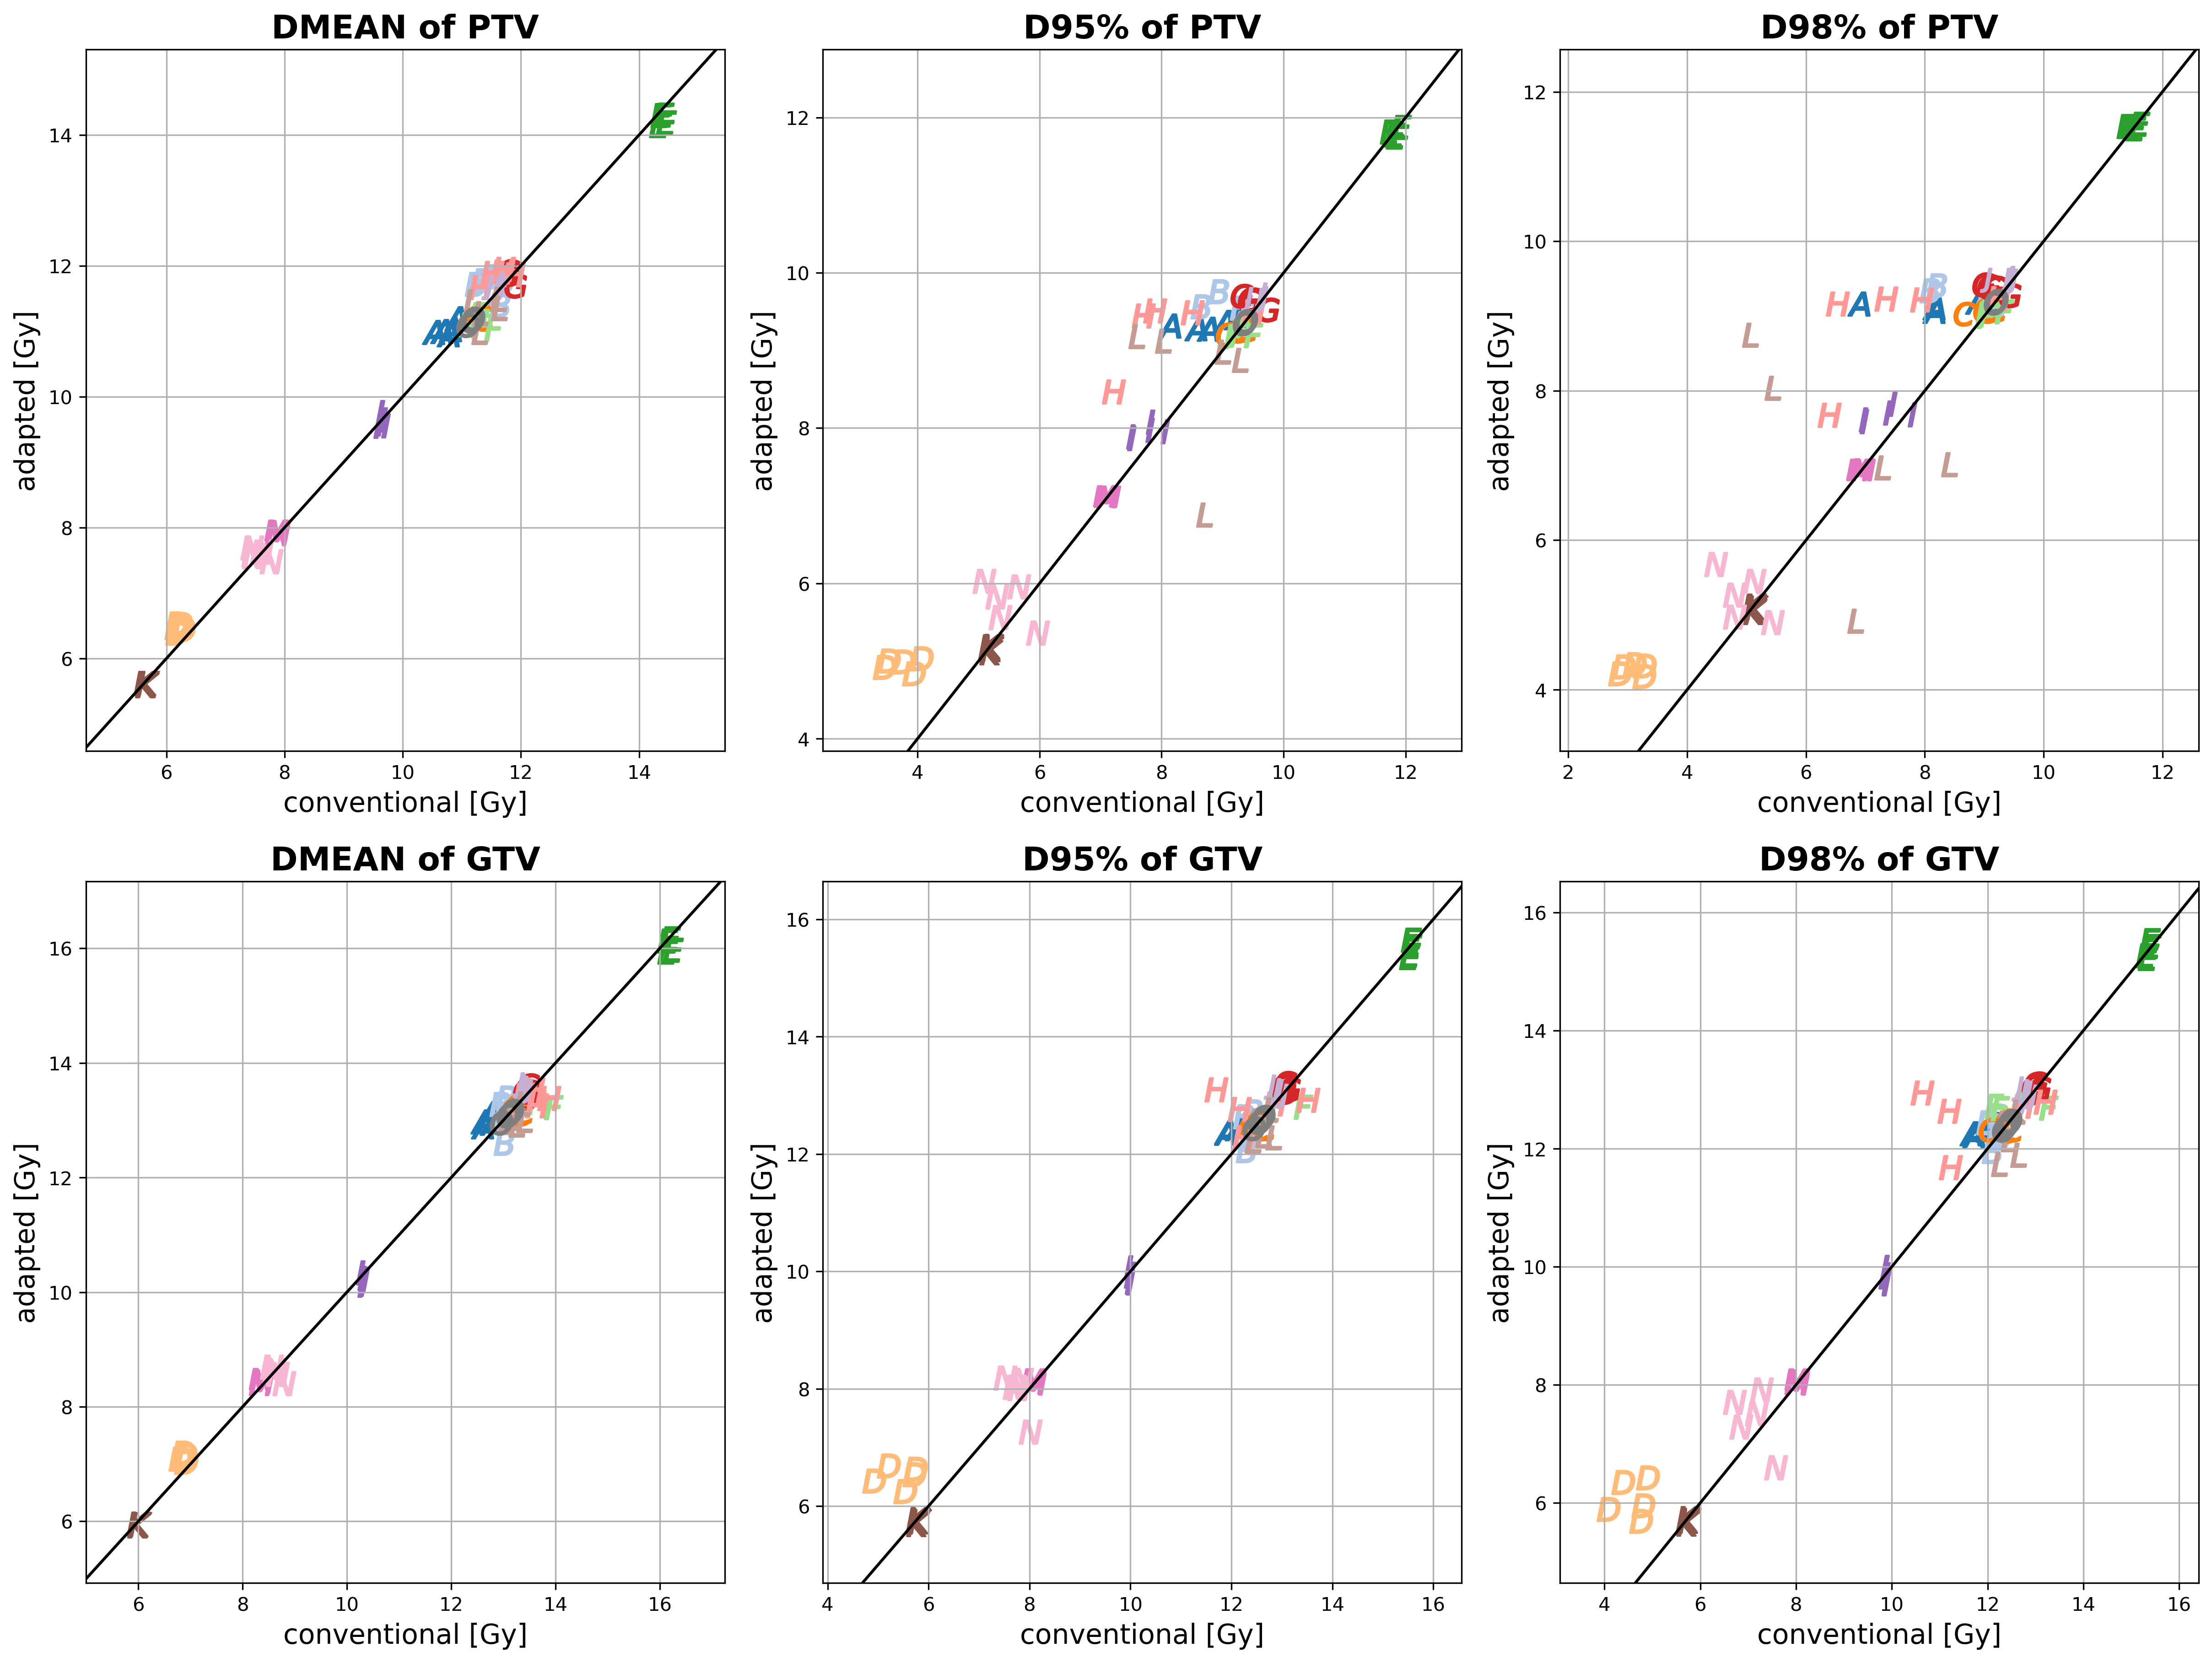

In [5]:
structures = ["PTV", "GTV"]
metrics = ["DMEAN", "D95%", "D98%"]

fig, ax = plt.subplots(len(structures), len(metrics), figsize=(16,12), constrained_layout=True)

for i,s in enumerate(structures):    # looping through the previously defined structures
    for j,m in enumerate(metrics):   # looping through the previously defined metrics
        x, y, c = con_vs_art(data, structure=s, metric=m)   # get the data for the structure & metric that's being plotted now
        # plot for every patient k
        [ax[i,j].scatter(x=x[k],y=y[k],c=c[k], s=150, marker=letters[c][k], cmap="tab20", vmin=0, vmax=19) for k in range(len(x))]
        ax[i,j].axline((0.,0.), slope=1., color="black")    # add the diagonal lines that separate good from bad
        ax[i,j].set_xlim([np.min(x)-1, np.max(x)+1])
        ax[i,j].set_ylim([np.min(y)-1, np.max(y)+1])
        ax[i,j].set_title(f"{m} of {s}", fontweight="bold", fontsize="xx-large")
        ax[i,j].set_xlabel("conventional [Gy]", fontsize="x-large")
        ax[i,j].set_ylabel("adapted [Gy]", fontsize="x-large")
        ax[i,j].grid()

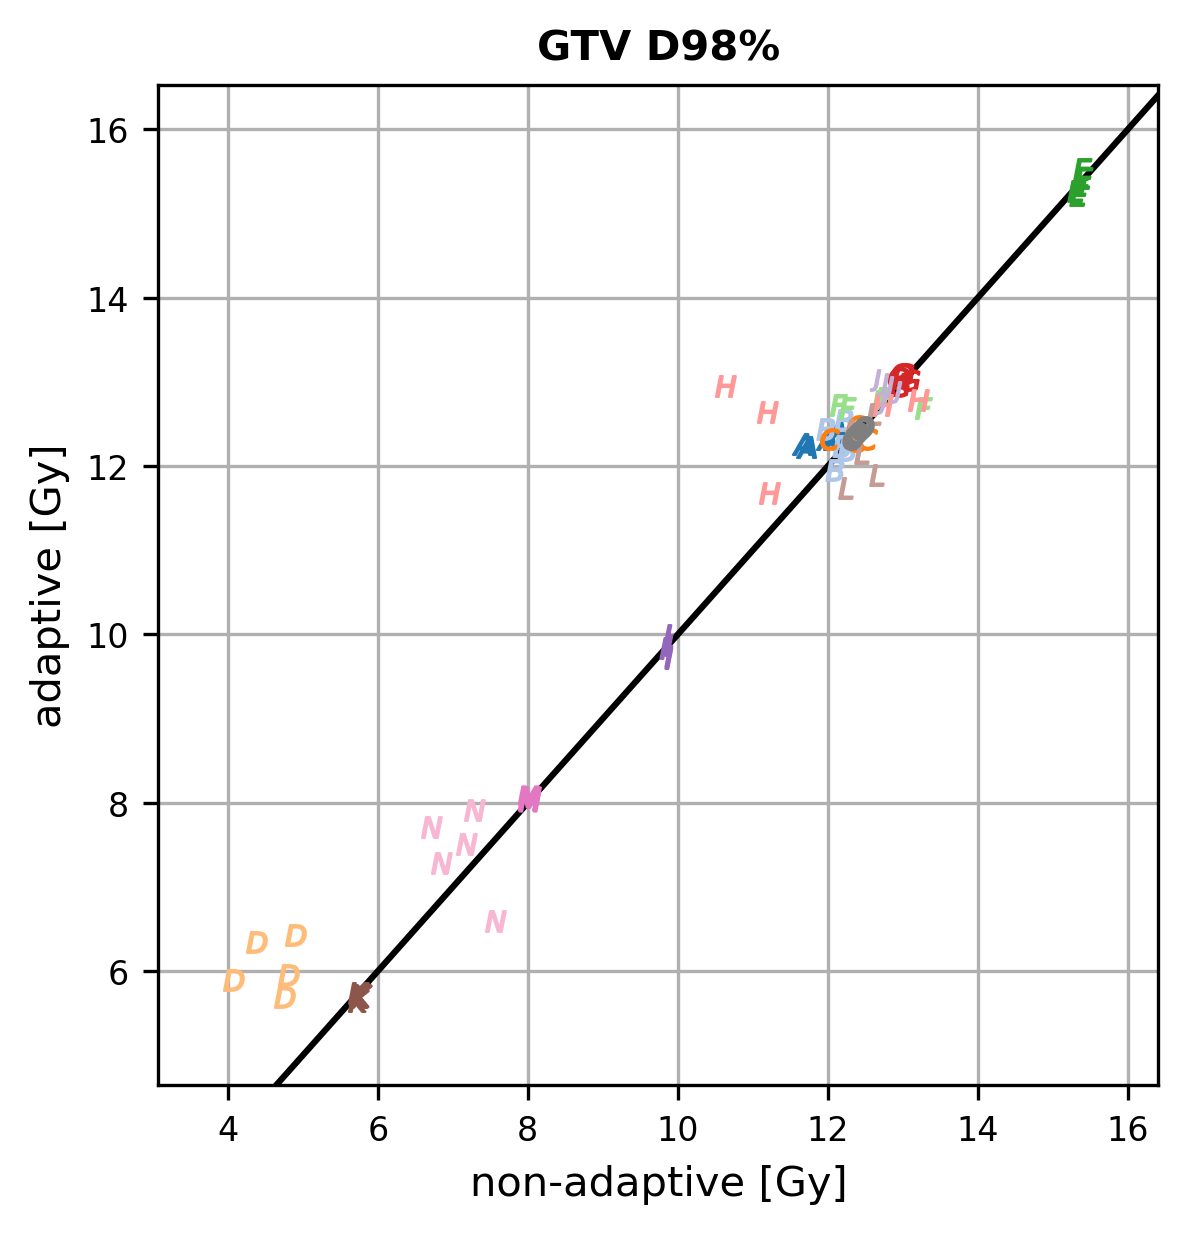

In [6]:
s = "GTV"
m = "D98%"

if 'D' in m:
    unit = 'Gy'
else:
    unit = '%'

fig, ax = plt.subplots(figsize=(6.3,4), constrained_layout=True)

x, y, c = con_vs_art(data, structure=s, metric=m)   # get the data for the structure & metric that's being plotted now
# plot for every patient k
[ax.scatter(x=x[k],y=y[k],c=c[k], s=25, lw=0.5, marker=letters[c][k], cmap="tab20", vmin=0, vmax=19, zorder=3) for k in range(len(x))]
ax.axline((0.,0.), slope=1., color="black")    # add the diagonal lines that separate good from bad
ax.set_xlim([np.min(x)-1, np.max(x)+1])
ax.set_ylim([np.min(y)-1, np.max(y)+1])
ax.set_title(f"{s} {m}",  fontsize=10, fontweight="bold")
ax.set_xlabel(f"non-adaptive [{unit}]", fontsize=10)
ax.set_ylabel(f"adaptive [{unit}]", fontsize=10)
ax.tick_params(labelsize=8)
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid()

# plt.savefig(plot_path/f"scatter_{s}_{m}.png", dpi=300)
# plt.savefig(plot_path/f"scatter_{s}_{m}.svg")

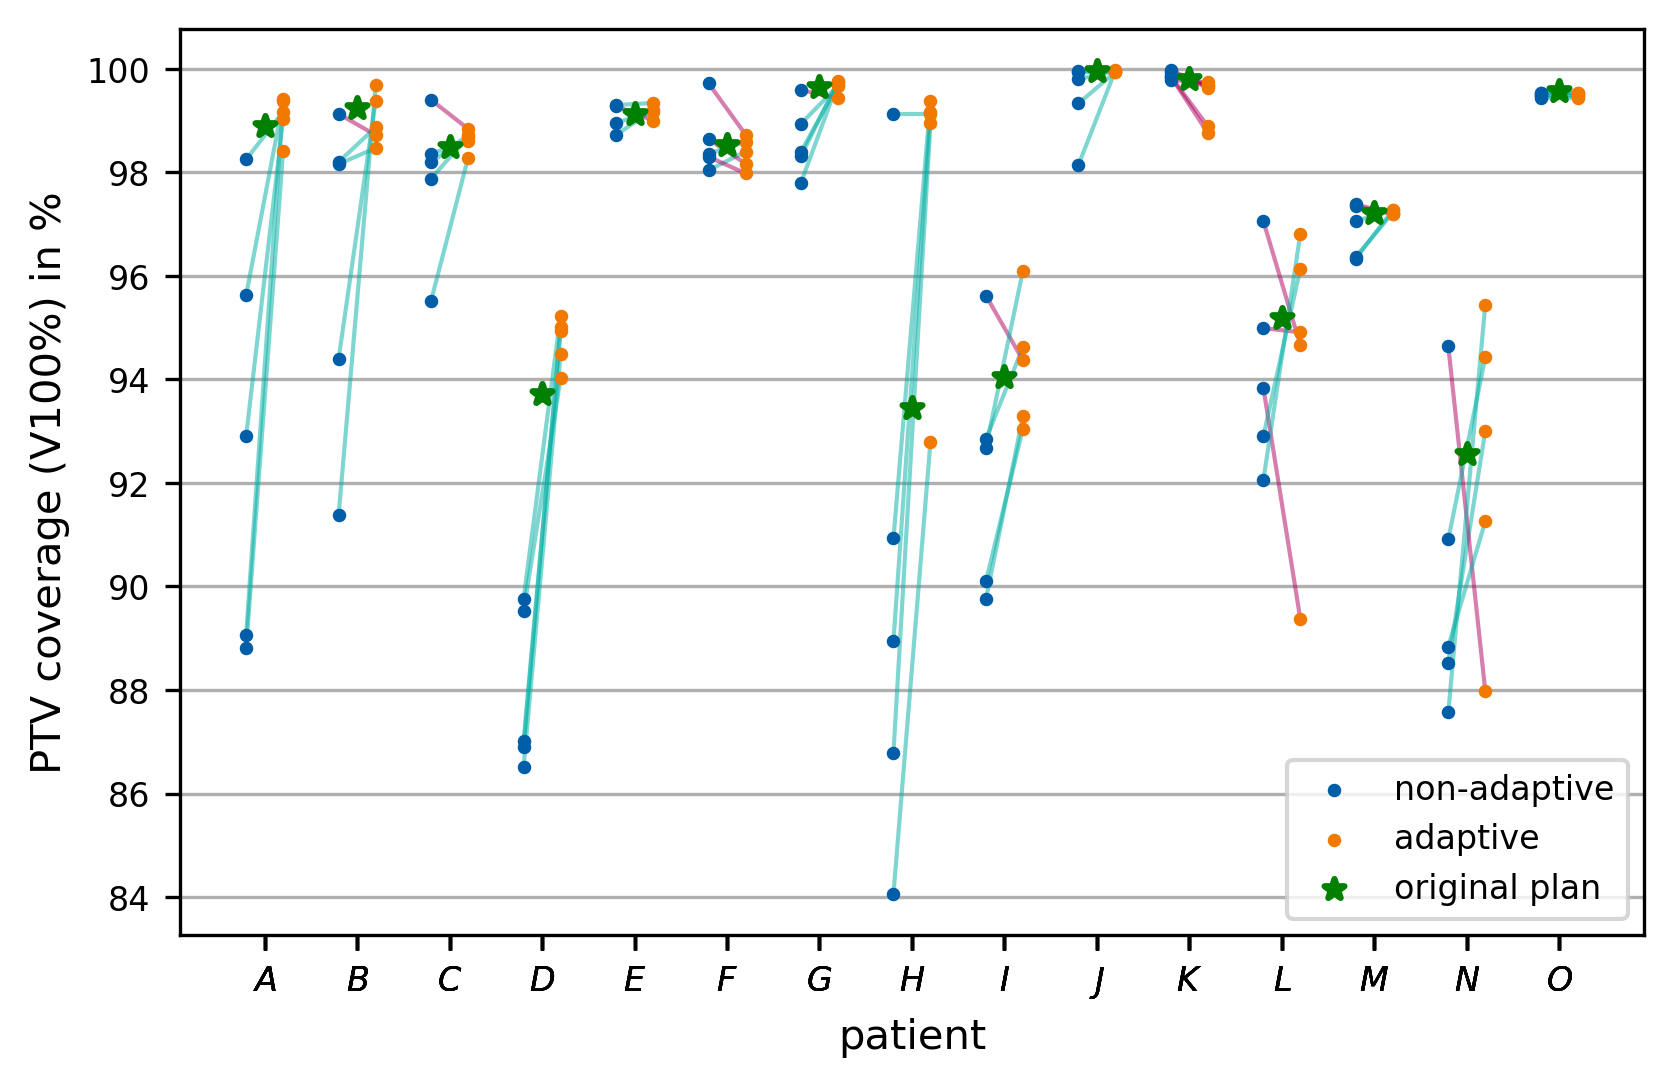

In [7]:
ori = data.loc[(data["type"]=="original") & (data["structure"]=="PTV") & (data["metric"]=="V100%"), "value"].values

x, y, c = con_vs_art(data, metric="V100%", structure="PTV")
uni_c = np.asarray(list(set(c)))

fig, ax = plt.subplots(figsize=(6.3, 4))

ax.scatter(5*c, x, color=usz_blue, s=5, marker='o', lw=1, zorder=3, label="non-adaptive")
ax.scatter(5*c+2, y, color=usz_orange, s=5, marker='o', lw=1, zorder=3, label="adaptive")
ax.scatter(5*uni_c+1, ori, color='g', s=25, marker='*', lw=1.5, zorder=3, label="original plan")

for i in range(len(x)):
    if x[i] <= y[i]:
        ax.plot([5*c[i], 5*c[i]+2], [x[i], y[i]], color=usz_green, lw=1, alpha=0.5)
    else:
        ax.plot([5*c[i], 5*c[i]+2], [x[i], y[i]], color=usz_red, lw=1, alpha=0.5)
    
ax.grid(axis='y')
ax.set_xlabel("patient", fontsize=10)
ax.set_ylabel("PTV coverage (V100%) in %", fontsize=10)
ax.legend(fontsize=8)
ax.tick_params(labelsize=8)
    
plt.xticks(5*c+1, labels=letters[c]);

# plt.savefig(plot_path/"coverage_all_scans.png", bbox_inches="tight", dpi=300)
# plt.savefig(plot_path/"coverage_all_scans.svg", bbox_inches="tight")

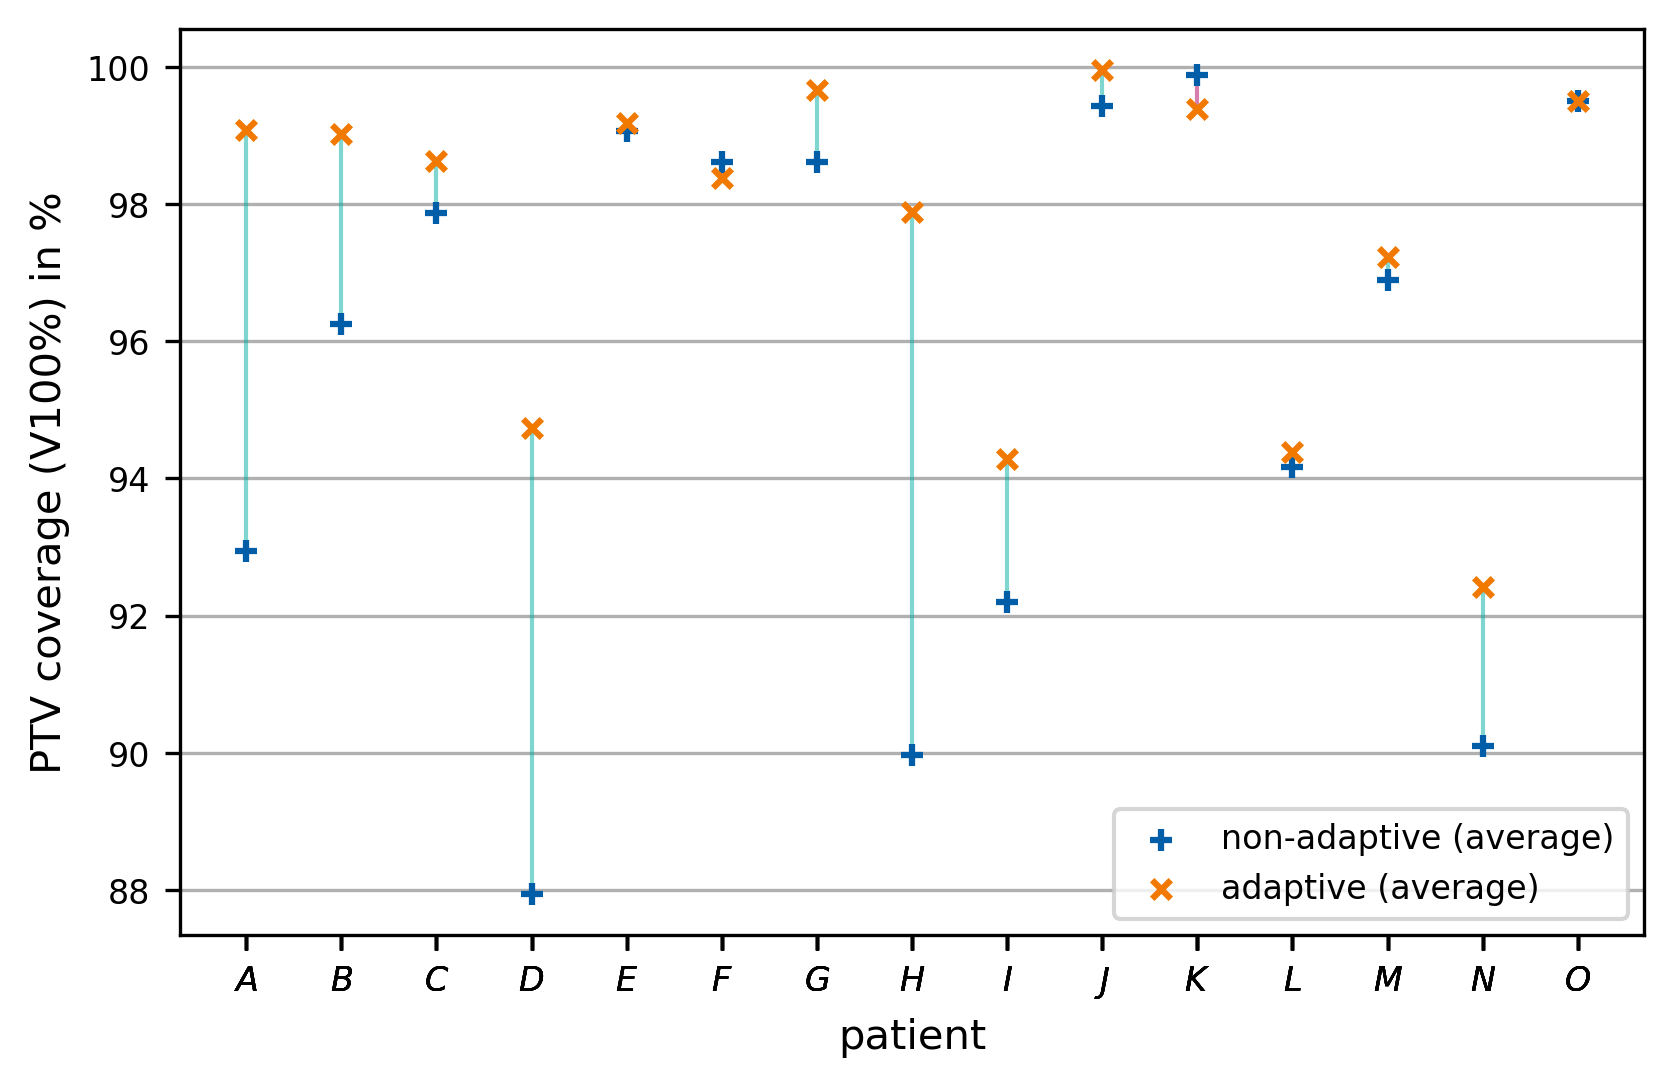

In [14]:
x_raw, y_raw, c = con_vs_art(data, metric="V100%", structure="PTV")
uni_c = np.asarray(list(set(c)))
x = [np.average(x_raw[c==i]) for i in uni_c]
y = [np.average(y_raw[c==i]) for i in uni_c]

fig, ax = plt.subplots(figsize=(6.3, 4))

ax.scatter(uni_c, x, color=usz_blue, s=30, marker='+', lw=1.5, zorder=3, label="non-adaptive (average)")
ax.scatter(uni_c, y, color=usz_orange, s=20, marker='x', lw=1.5, zorder=3, label="adaptive (average)")
# ax.scatter(c, ori, color='g', s=100, marker='_', lw=2, zorder=3, label="original")

for i in range(len(x)):
    if x[i] <= y[i]:
        ax.plot([uni_c[i], uni_c[i]], [x[i], y[i]], color=usz_green, lw=1, alpha=0.5)
    else:
        ax.plot([uni_c[i], uni_c[i]], [x[i], y[i]], color=usz_red, lw=1, alpha=0.5)
    
ax.grid(axis='y')
ax.set_xlabel("patient", fontsize=10)
ax.set_ylabel("PTV coverage (V100%) in %", fontsize=10)
ax.legend(fontsize=8)
ax.tick_params(labelsize=8)
    
plt.xticks(c, labels=letters[c]);

plt.savefig(plot_path/"coverage_average.png", dpi=300, bbox_inches="tight")
plt.savefig(plot_path/"coverage_average.svg", bbox_inches="tight")

How many patients got an improvement of their PTV coverage?

In [9]:
x, y, c = con_vs_art(data, structure="PTV", metric="V100%")
better = np.sum(np.greater(y-x,0))
better_percent = better / len(x)
worse = np.sum(np.greater(x-y,0))
worse_percent = worse / len(x)
same = np.sum(np.equal(x-y, 0))
same_percent = same / len(x)

print(f"{better} fractions ({better_percent*100:.2f} %) received a better PTV coverage through daily adaptive fractionation")
print(f"For {worse} fractions ({worse_percent*100:.2f} %) the adaptive fractionation resulted in worse PTV coverage")
print(f"In {same} fraction, no change was observed ({same_percent*100:.2f} %)")
print(f"Total number of fractions: {len(x)}")

47 fractions (62.67 %) received a better PTV coverage through daily adaptive fractionation
For 20 fractions (26.67 %) the adaptive fractionation resulted in worse PTV coverage
In 8 fraction, no change was observed (10.67 %)
Total number of fractions: 75


#### OAR
Same kind of plots for the organ at risk structures

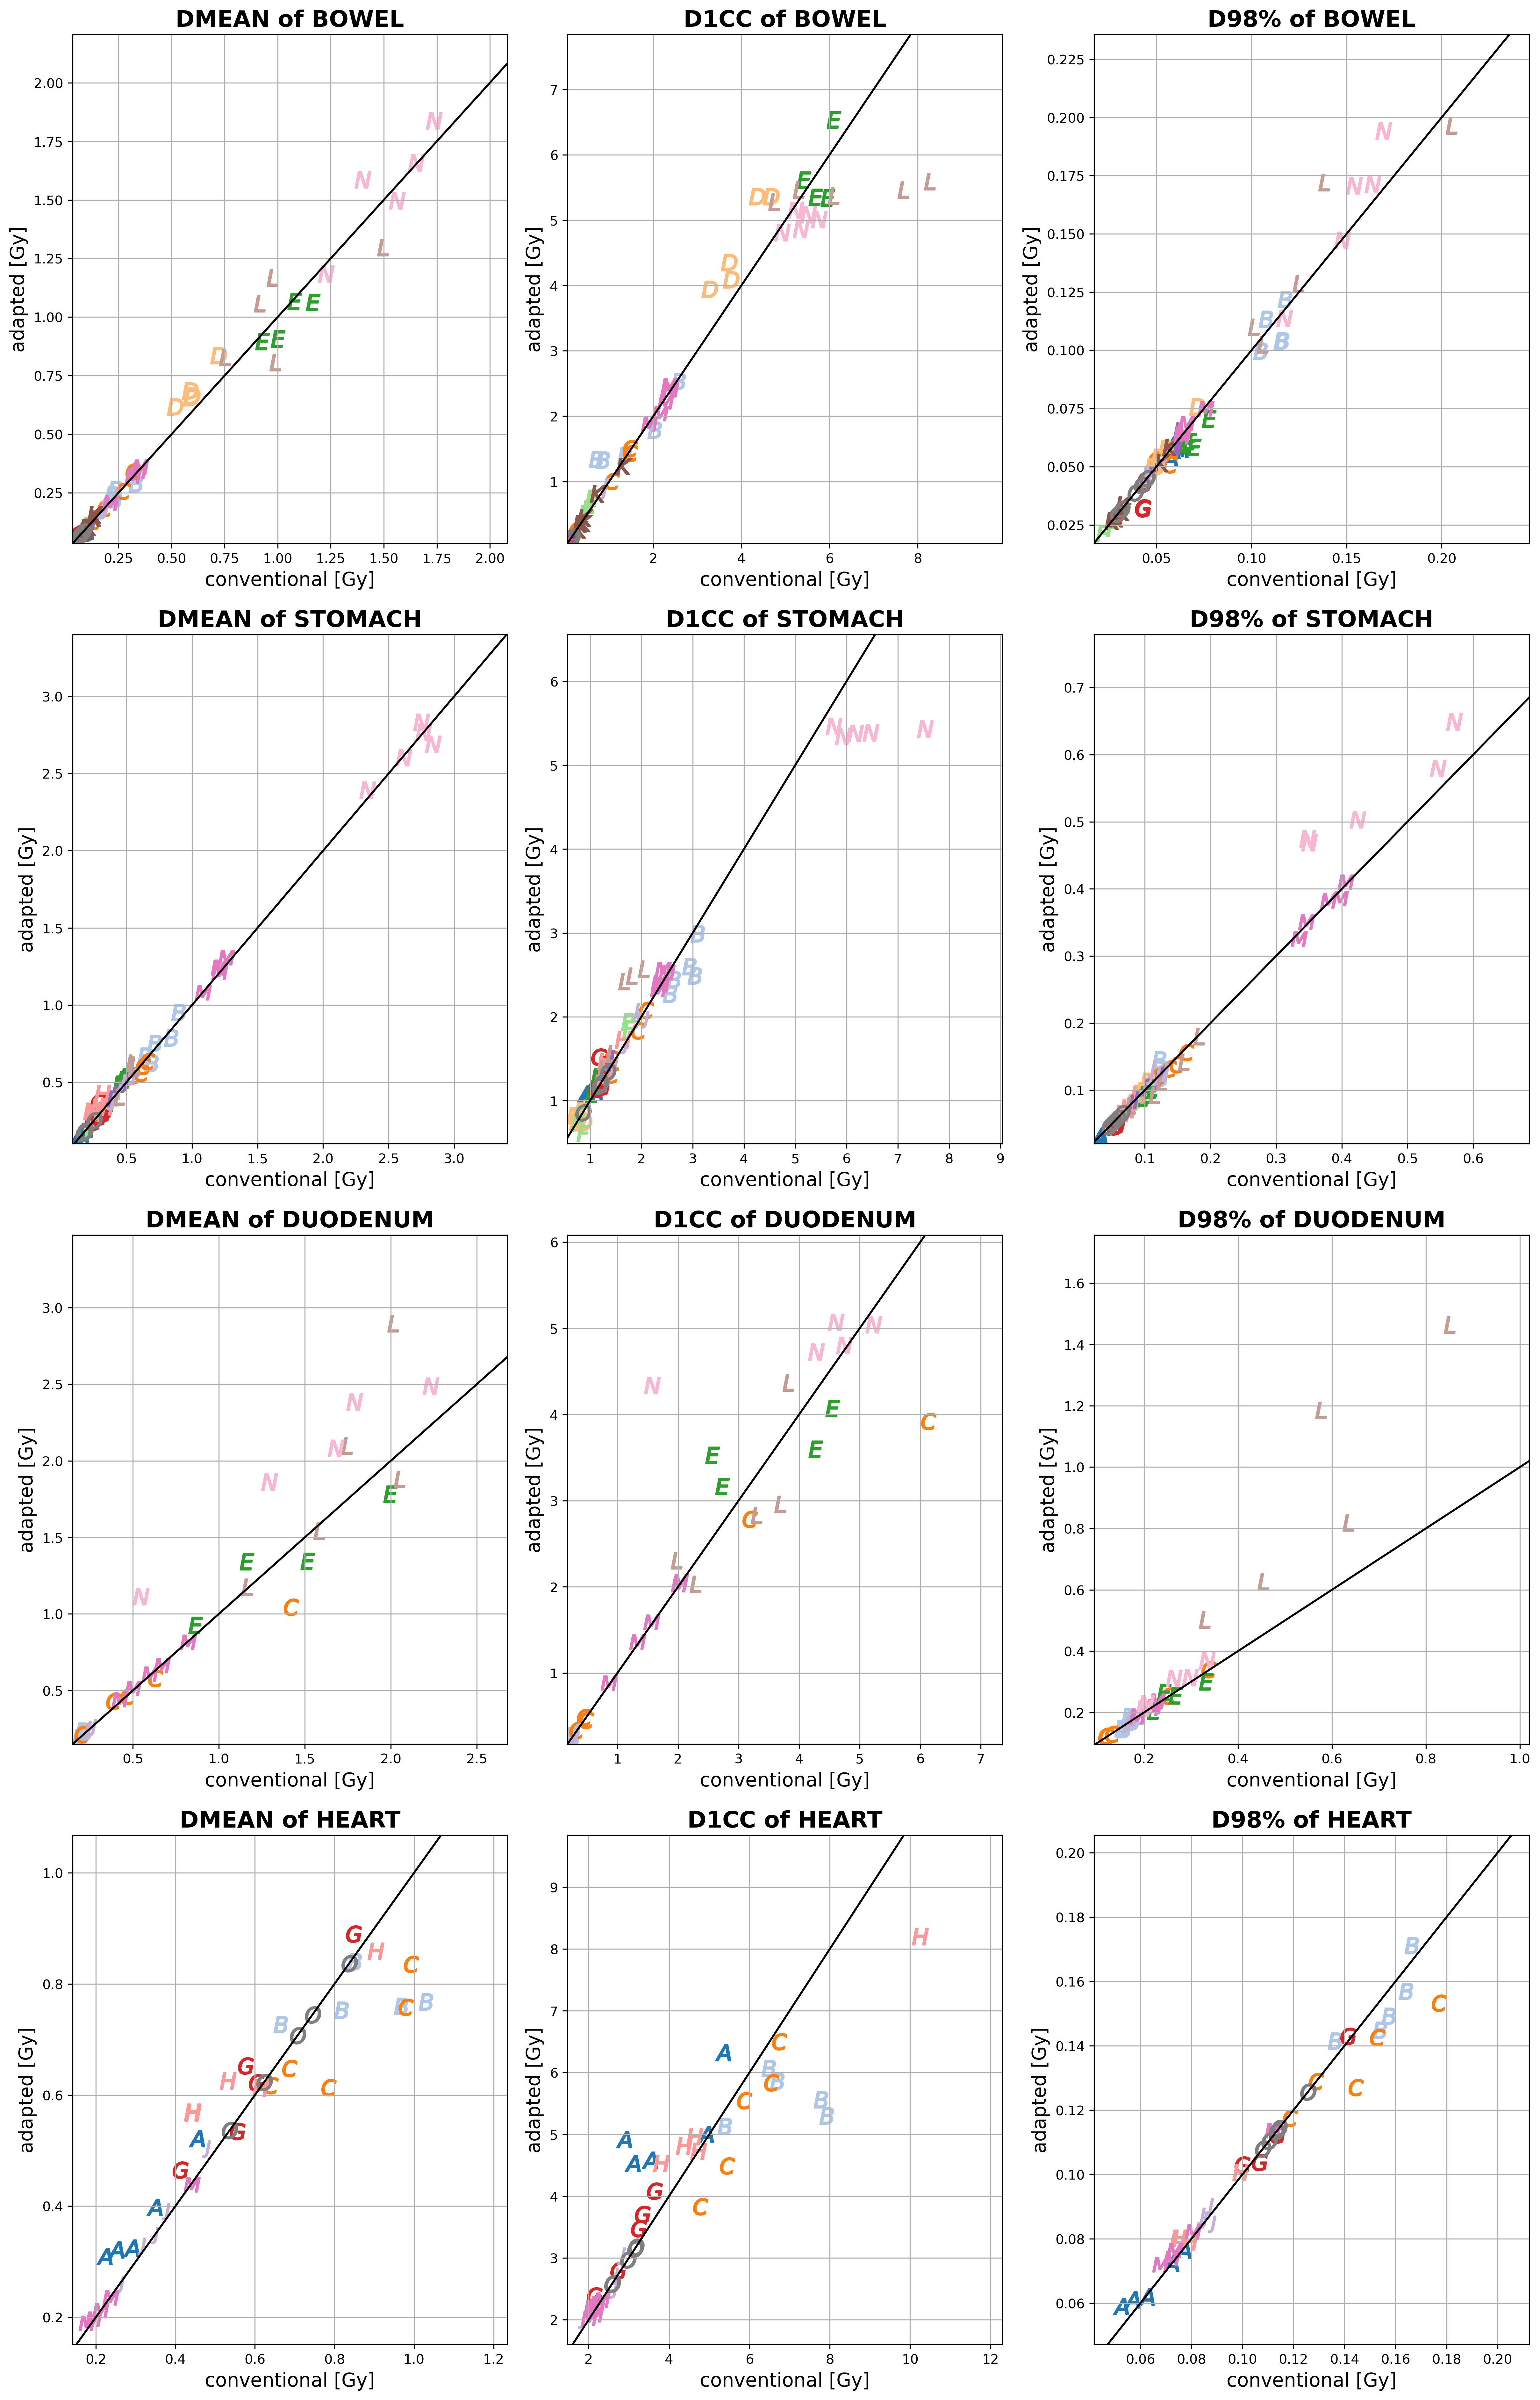

In [11]:
structures = ["BOWEL", "STOMACH", "DUODENUM", "HEART"]
metrics = ["DMEAN", "D1CC", "D98%"]

fig, ax = plt.subplots(len(structures), len(metrics), figsize=(16,25), constrained_layout=True)

for i,s in enumerate(structures):
    for j,m in enumerate(metrics):
        x, y, c = con_vs_art(data, structure=s, metric=m)
        [ax[i,j].scatter(x=x[k],y=y[k],c=c[k], s=150, marker=letters[c][k], cmap="tab20", vmin=0, vmax=19) for k in range(len(x))]
        ax[i,j].axline((0.,0.), slope=1., color="black")
        ax[i,j].set_xlim([np.min(x)*0.8, np.max(x)*1.2])
        ax[i,j].set_ylim([np.min(y)*0.8, np.max(y)*1.2])
        ax[i,j].set_title(f"{m} of {s}", fontweight="bold", fontsize="xx-large")
        ax[i,j].set_xlabel("conventional [Gy]", fontsize="x-large")
        ax[i,j].set_ylabel("adapted [Gy]", fontsize="x-large")
        ax[i,j].grid()

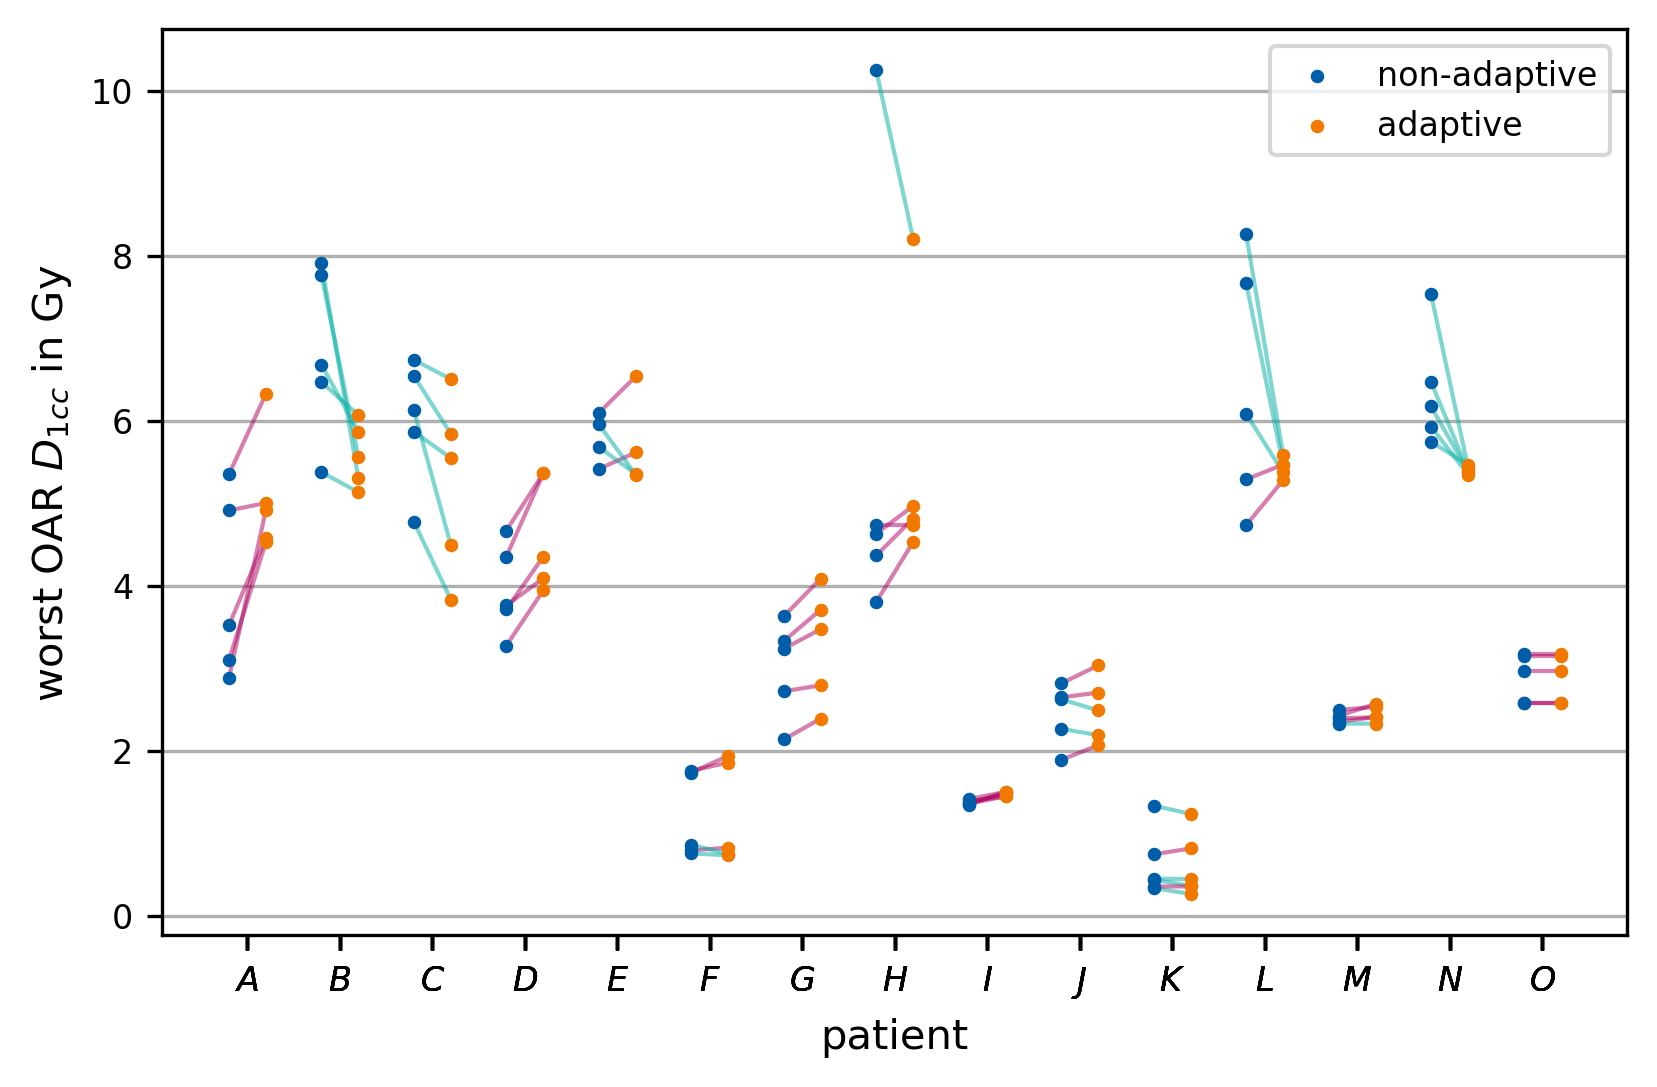

In [8]:
ori = data.loc[(data["type"]=="original") & (data["structure"]=="max") & (data["metric"]=="D1CC"), "value"].values

x, y, c = con_vs_art(data, metric="D1CC", structure="max")
uni_c = np.asarray(list(set(c)))

fig, ax = plt.subplots(figsize=(6.3, 4))

ax.scatter(5*c, x, color=usz_blue, s=5, marker='o', lw=1, zorder=3, label="non-adaptive")
ax.scatter(5*c+2, y, color=usz_orange, s=5, marker='o', lw=1, zorder=3, label="adaptive")
# ax.scatter(5*uni_c+1, ori, color='g', s=25, marker='*', lw=1.5, zorder=3, label="original plan")

for i in range(len(x)):
    if x[i] <= y[i]:
        ax.plot([5*c[i], 5*c[i]+2], [x[i], y[i]], color=usz_red, lw=1, alpha=0.5)
    else:
        ax.plot([5*c[i], 5*c[i]+2], [x[i], y[i]], color=usz_green, lw=1, alpha=0.5)
    
ax.grid(axis='y')
ax.set_xlabel("patient", fontsize=10)
ax.set_ylabel(r"worst OAR $D_{1cc}$ in Gy", fontsize=10)
ax.legend(fontsize=8)
ax.tick_params(labelsize=8)
    
plt.xticks(5*c+1, labels=letters[c]);

plt.savefig(plot_path/"maxdose_all_scans.png", bbox_inches="tight", dpi=300)
plt.savefig(plot_path/"maxdose_all_scans.svg", bbox_inches="tight")

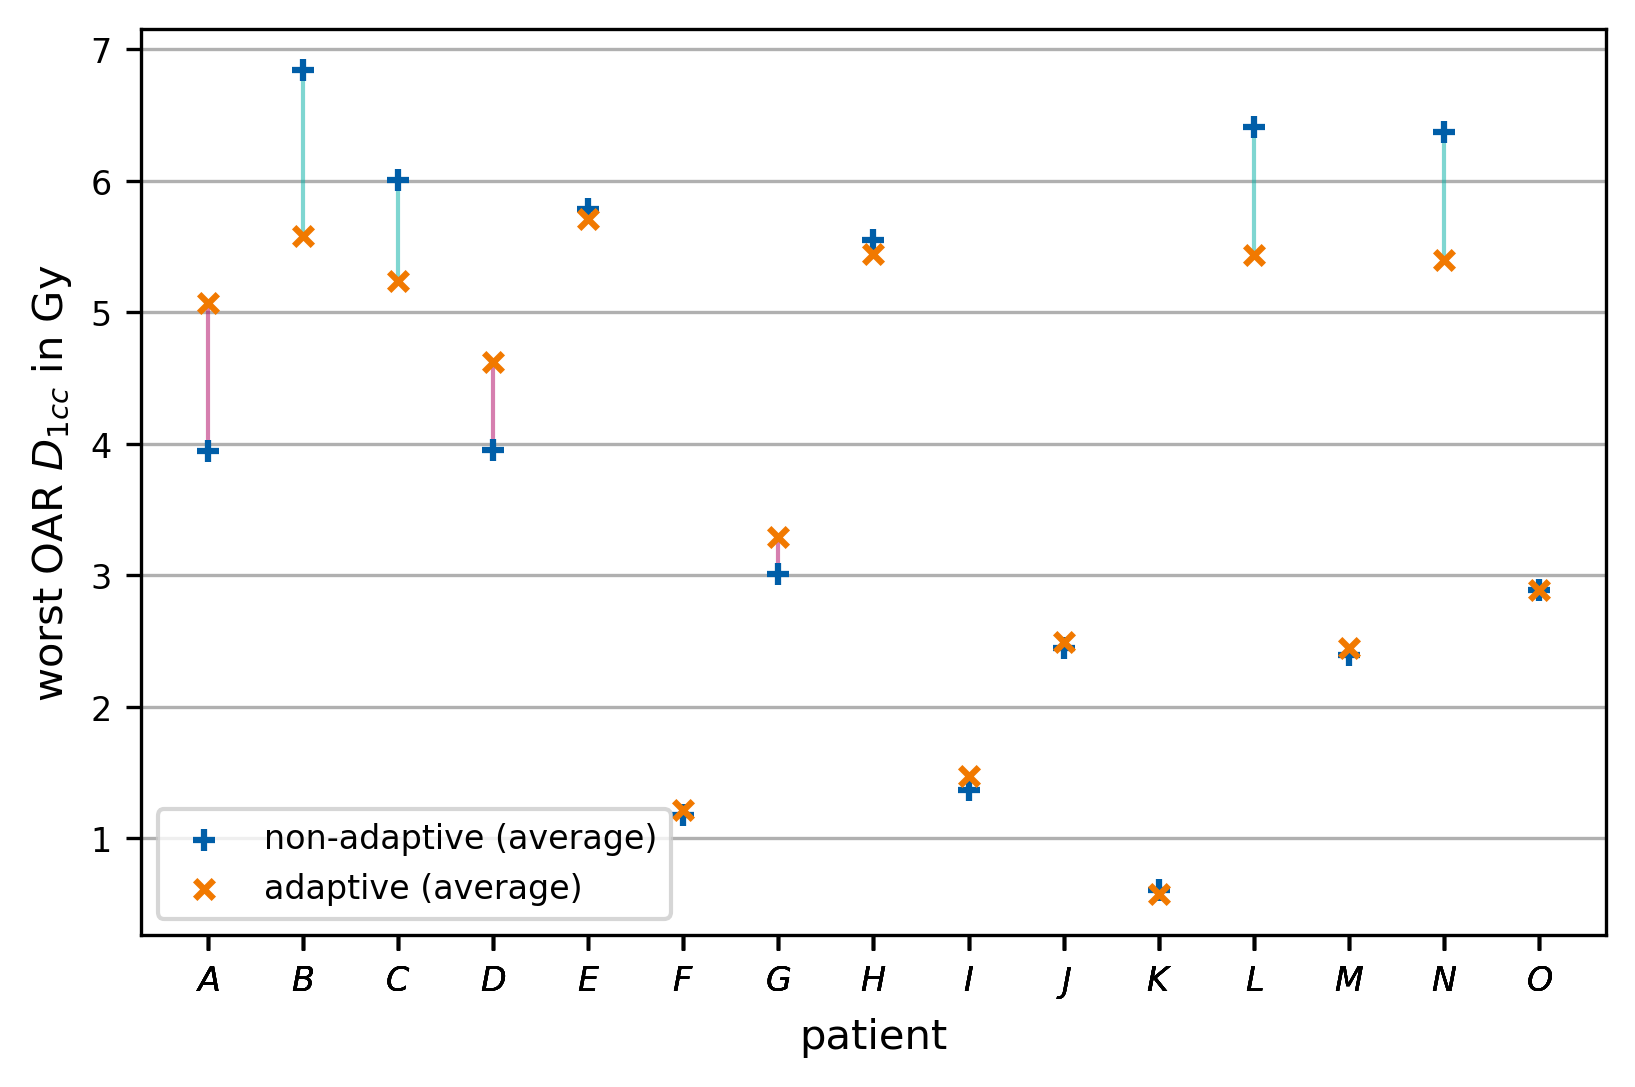

In [13]:
x_raw, y_raw, c = con_vs_art(data, metric="D1CC", structure="max")
uni_c = np.asarray(list(set(c)))
x = [np.average(x_raw[c==i]) for i in uni_c]
y = [np.average(y_raw[c==i]) for i in uni_c]

fig, ax = plt.subplots(figsize=(6.3, 4))

ax.scatter(uni_c, x, color=usz_blue, s=30, marker='+', lw=1.5, zorder=3, label="non-adaptive (average)")
ax.scatter(uni_c, y, color=usz_orange, s=20, marker='x', lw=1.5, zorder=3, label="adaptive (average)")
# ax.scatter(c, ori, color='g', s=100, marker='_', lw=2, zorder=3, label="original")

for i in range(len(x)):
    if x[i] <= y[i]:
        ax.plot([uni_c[i], uni_c[i]], [x[i], y[i]], color=usz_red, lw=1, alpha=0.5)
    else:
        ax.plot([uni_c[i], uni_c[i]], [x[i], y[i]], color=usz_green, lw=1, alpha=0.5)
    
ax.grid(axis='y')
ax.set_xlabel("patient", fontsize=10)
ax.set_ylabel(r"worst OAR $D_{1cc}$ in Gy", fontsize=10)
ax.legend(fontsize=8)
ax.tick_params(labelsize=8)
    
plt.xticks(c, labels=letters[c]);

plt.savefig(plot_path/"maxdose_average.png", dpi=300, bbox_inches="tight")
plt.savefig(plot_path/"maxdose_average.svg", bbox_inches="tight")

#### Distances
Minimal distance of PTV to OAR plotted vs the improvement of the PTV coverage in percent. For patients where OAR and PTV were overlapping, the distance is depicted as "negative" to separate them visually.

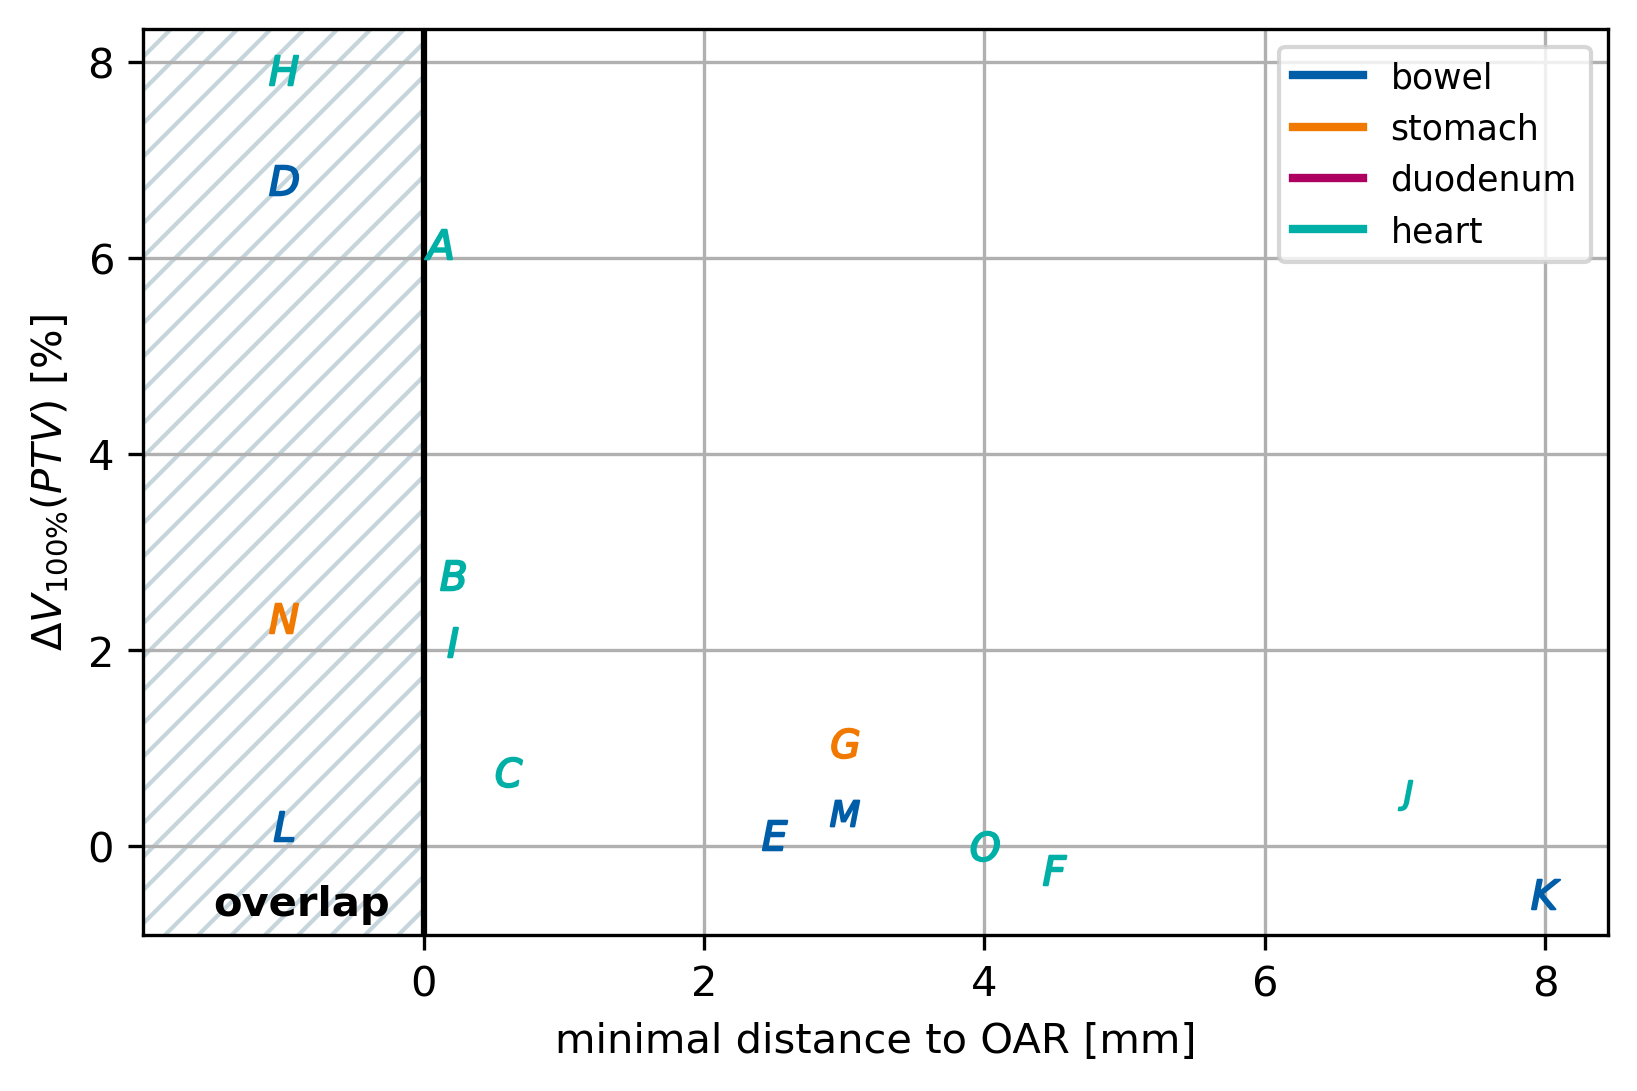

In [28]:
struct_dict = {"BOWEL": usz_blue, "STOMACH": usz_orange, "DUODENUM": usz_red, "HEART": usz_green}
pat = distances["patient"].values
dist = distances["distance"].values
impro = distances["change"].values
oar = [oar.upper() for oar in distances["organ"].values]


fig, ax = plt.subplots(figsize=(6.3, 4))

# ax.scatter(dist, impro, marker=letters[])
[ax.scatter(x=dist[i],y=impro[i],c=struct_dict[oar[i]], s=50, lw=0.5, marker=letters[k], cmap="tab20", vmin=0, vmax=19, zorder=3) for i,k in enumerate(pat)];
ax.set_xlim(left=-2)
ax.set_xticks(np.linspace(0., 8., 5))
ax.set_xlabel("minimal distance to OAR [mm]", fontsize=10)
ax.set_ylabel(r"$\Delta V_{100\%}(PTV)$ [%]", fontsize=10)
ax.grid()

custom_lines = [Line2D([0], [0], color=usz_blue, lw=2),
                Line2D([0], [0], color=usz_orange, lw=2),
                Line2D([0], [0], color=usz_red, lw=2),
                Line2D([0], [0], color=usz_green, lw=2)]
ax.legend(custom_lines, [k.lower() for k in struct_dict], fontsize="small")

matplotlib.rcParams["hatch.color"] = usz_gray
rect = matplotlib.patches.Rectangle((-2,-1), 2, 10, hatch="///", alpha=0.)

ax.add_patch(rect)
ax.text(x=-1.5, y=-0.7, s="overlap", color='k', fontweight="bold")
ax.axvline(0., color="black")

# plt.savefig(plot_path/"distance.png", bbox_inches="tight", dpi=300)
# plt.savefig(plot_path/"distance.svg", bbox_inches="tight")

#### Quadrant plots
The idea behind this plot is that we can compute the difference between ART and conventional plans. Then the sign of the result will tell us whether we have improvements or not. So if we compute

$$
\Delta D_{1cm^3}(\text{bowel}) = D_{1cm^3}^{con}(\text{bowel}) - D_{1cm^3}^{ART}(\text{bowel})
$$

this quantity will be positive if the adaptive treatment has brought us any imporovement regarding the OARs. Similarily, the quantity

$$
\Delta V_{100\%}(\text{PTV}) = V_{100\%}^{ART}(\text{PTV}) - V_{100\%}^{con}(\text{PTV})
$$

will be positive, when we observa an imporvement with respect to the PTV coverage in adaptive radiotherapy. Plotting these two differences along x- and y-axis of a scatter plot respectively, we will see points that posittion themselves in four quadrants: The top right, where both are positive and the daily adaption has only improved the treatment quality; the lower left corner, where the treatment plan is worse w.r.t. both metrics and then the remaining two (upper left & lower right), where there is some compromise.

Text(-6, -2.5, 'worsening')

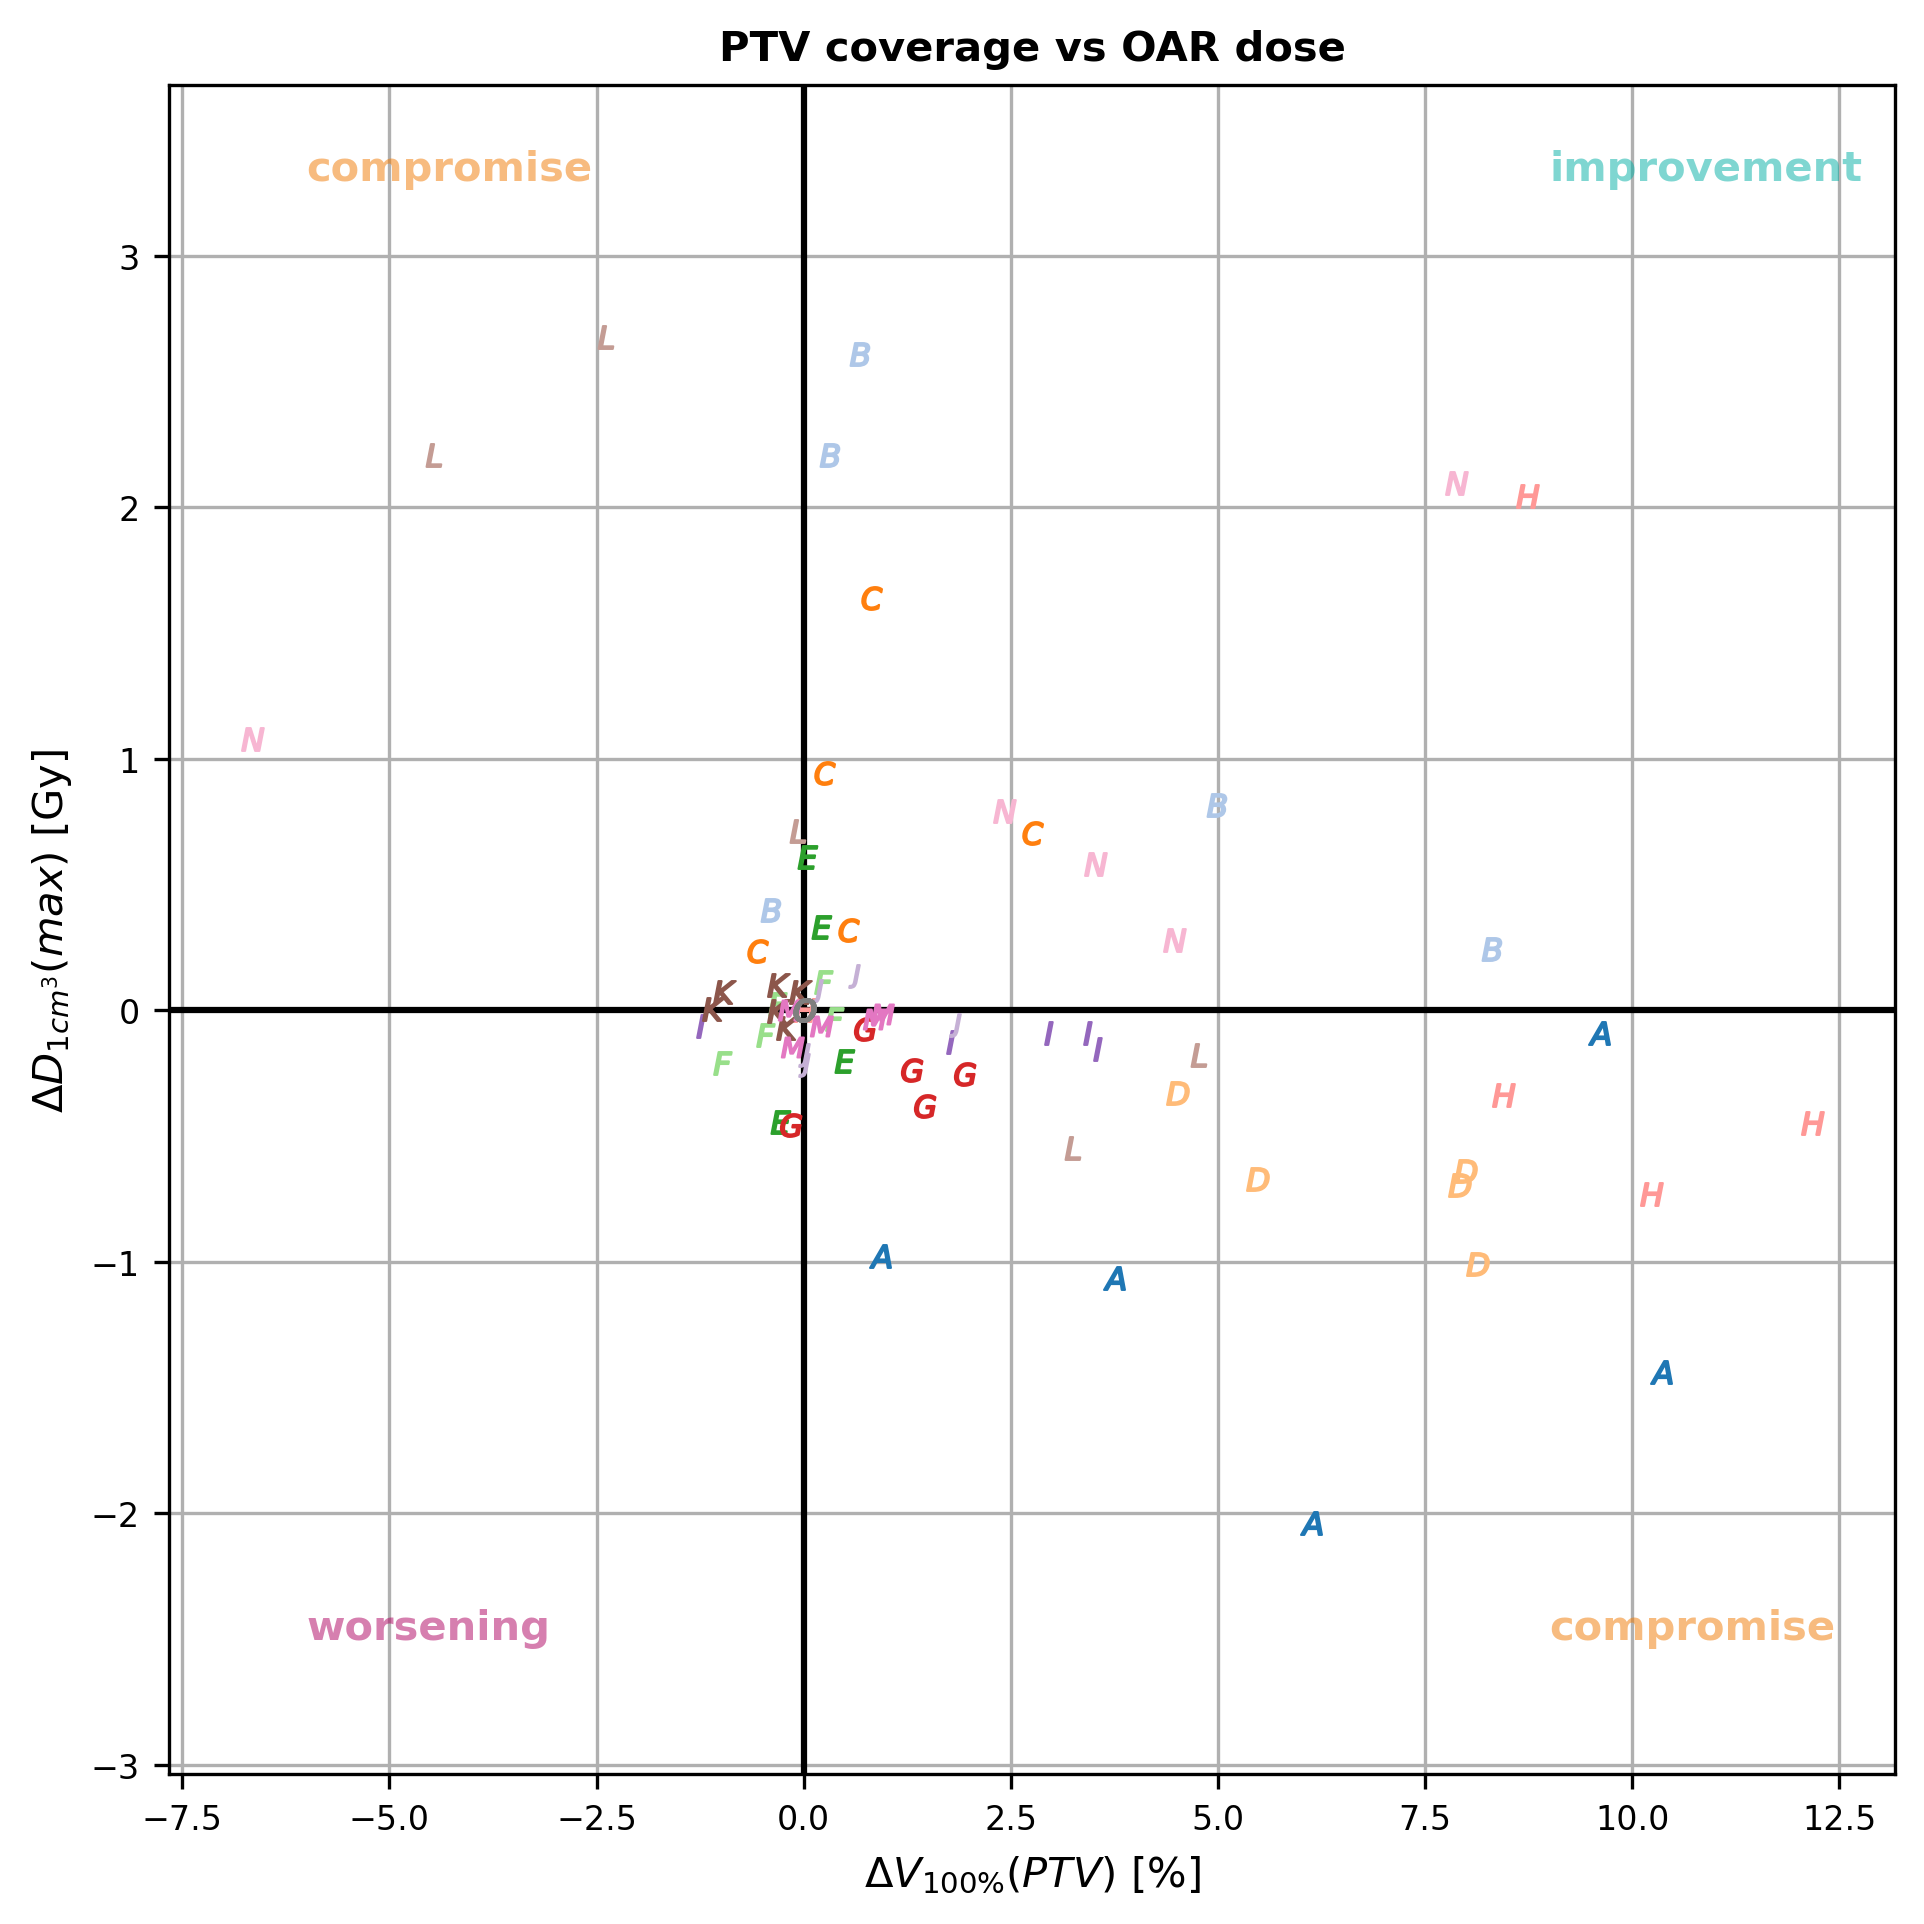

In [14]:
tumor_s = "PTV"
OAR_s = "max"

x_con, x_art, ca = con_vs_art(data, structure=tumor_s, metric="V100%")
y_con, y_art, cb = con_vs_art(data, structure=OAR_s, metric="D1CC")

x = (x_art - x_con)#[ca != 11]  # exclude patient 11, as he does not have STOMACH or DUODENUM
y = y_con - y_art

fig, ax = plt.subplots(figsize=(6.3,6.3), constrained_layout=True)

# plot for every patient k
[ax.scatter(x=x[k],y=y[k],c=ca[k], s=30, lw=0.5, marker=letters[ca][k], cmap="tab20", vmin=0, vmax=19, zorder=3) for k in range(len(x))]
ax.set_xlim([np.min(x)-1, np.max(x)+1])
ax.set_ylim([np.min(y)-1, np.max(y)+1])
ax.set_title("PTV coverage vs OAR dose",  fontsize=10, fontweight="bold")
ax.axvline(0., color="black")
ax.axhline(0., color="black")
# ax.set_xlabel(f"{tumor_s}: " + r"$V_{100\%}^{ART} - V_{100\%}^{CON}$ [%]", fontsize=10)
ax.set_xlabel(r"$\Delta V_{100\%}(PTV)$ [%]", fontsize=10)
# ax.set_ylabel(f"{OAR_s}: " + r"$D_{1cm^3}^{CON} - D_{1cm^3}^{ART}$ [Gy]" , fontsize=10)
ax.set_ylabel(r"$\Delta D_{1cm^3}(max)$ [Gy]" , fontsize=10)
ax.tick_params(labelsize=8)
ax.grid()

ax.text(x=9, y=3.3, s="improvement", color=usz_green, alpha=0.5, fontweight="bold")
ax.text(x=-6, y=3.3, s="compromise", color=usz_orange, alpha=0.5, fontweight="bold")
ax.text(x=9, y=-2.5, s="compromise", color=usz_orange, alpha=0.5, fontweight="bold")
ax.text(x=-6, y=-2.5, s="worsening", color=usz_red, alpha=0.5, fontweight="bold")

# plt.savefig(plot_path/f"difference_{OAR_s}_vs_{tumor_s}.png", bbox_inches="tight", dpi=300)
# plt.savefig(plot_path/f"difference_{OAR_s}_vs_{tumor_s}.svg", bbox_inches="tight")

In [15]:
oar_impro = np.sum(np.greater_equal(0., y))
print(f"The highest D1cc of the considered organs at risk improved or stayed the same for {oar_impro*100/len(y)} % of the fractions ({oar_impro}/{len(y)})")

The highest D1cc of the considered organs at risk improved or stayed the same for 60.0 % of the fractions (45/75)


#### Conformity Index

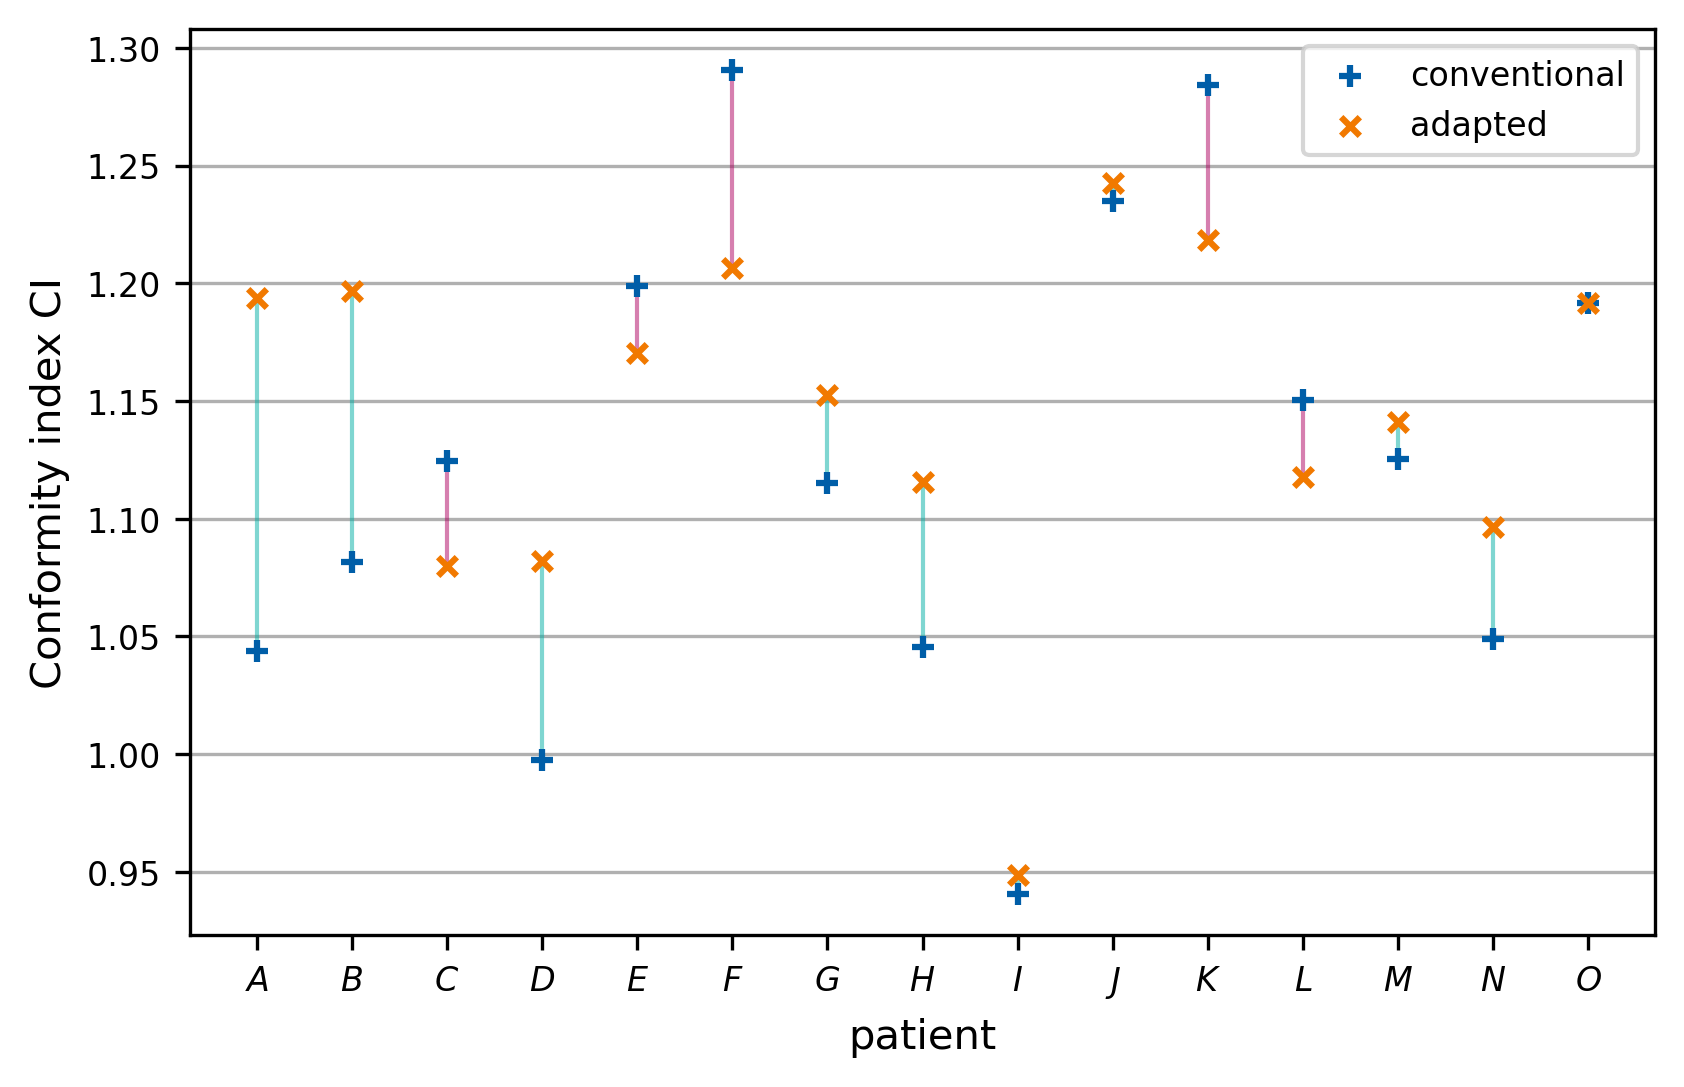

In [16]:
x = conformity_index["Con"].values
y = conformity_index["ART"].values
c = conformity_index["patient"].values

fig, ax = plt.subplots(figsize=(6.3, 4))

ax.scatter(c, x, color=usz_blue, s=30, marker='+', lw=1.5, zorder=3, label="conventional")
ax.scatter(c, y, color=usz_orange, s=20, marker='x', lw=1.5, zorder=3, label="adapted")

for i in range(len(x)):
    if x[i] <= y[i]:
        ax.plot([c[i], c[i]], [x[i], y[i]], color=usz_green, lw=1, alpha=0.5)
    else:
        ax.plot([c[i], c[i]], [x[i], y[i]], color=usz_red, lw=1, alpha=0.5)
    
ax.grid(axis='y')
ax.set_xlabel("patient", fontsize=10)
ax.set_ylabel("Conformity index CI", fontsize=10)
ax.legend(fontsize=8)
ax.tick_params(labelsize=8)
    
plt.xticks(c, labels=letters[c]);

# plt.savefig(plot_path/"conformity_index.png", bbox_inches="tight", dpi=300)
# plt.savefig(plot_path/"conformity_index.svg", bbox_inches="tight")

### Paired Wilcoxon Tests
#### Tumor

In [18]:
structures = ["PTV", "GTV"]
metrics = ["DMEAN", "D95%", "D98%"]

for i,s in enumerate(structures):
    for j,m in enumerate(metrics):
        x, y, c = con_vs_art(data, structure=s, metric=m)  # getting x and y from the little function up there
        statistic, pvalue = sp.stats.wilcoxon(x=x, y=y)    #  this is all we need to do to perform the test
        print(f"For structure {s}\t& metric {m}\twe have W = {int(statistic):4d} leading to p = {100*pvalue:5.2f} %")

For structure PTV	& metric DMEAN	we have W =  891 leading to p =  5.84 %
For structure PTV	& metric D95%	we have W =  558 leading to p =  0.01 %
For structure PTV	& metric D98%	we have W =  499 leading to p =  0.00 %
For structure GTV	& metric DMEAN	we have W = 1170 leading to p = 82.26 %
For structure GTV	& metric D95%	we have W =  824 leading to p =  2.19 %
For structure GTV	& metric D98%	we have W =  681 leading to p =  0.16 %


#### OAR

In [20]:
structures = ["BOWEL", "STOMACH", "DUODENUM", "HEART"]
metrics = ["DMEAN", "D1CC", "D98%"]

for i,s in enumerate(structures):
    for j,m in enumerate(metrics):
        x, y, c = con_vs_art(data, structure=s, metric=m)  # getting x and y from the little function up there
        statistic, pvalue = sp.stats.wilcoxon(x=x, y=y)    #  this is all we need to do to perform the test
        print(f"For structure {s}\t& metric {m}\twe have W = {int(statistic):4d} leading to p = {100*pvalue:5.2f} %")

For structure BOWEL	& metric DMEAN	we have W =  940 leading to p = 38.66 %
For structure BOWEL	& metric D1CC	we have W = 1002 leading to p = 64.50 %
For structure BOWEL	& metric D98%	we have W =  924 leading to p = 33.18 %
For structure STOMACH	& metric DMEAN	we have W =  555 leading to p =  0.19 %
For structure STOMACH	& metric D1CC	we have W =  777 leading to p = 11.38 %
For structure STOMACH	& metric D98%	we have W =  900 leading to p = 45.97 %
For structure DUODENUM	& metric DMEAN	we have W =  162 leading to p =  2.05 %
For structure DUODENUM	& metric D1CC	we have W =  241 leading to p = 33.41 %
For structure DUODENUM	& metric D98%	we have W =  149 leading to p =  1.11 %
For structure HEART	& metric DMEAN	we have W =  262 leading to p = 54.39 %
For structure HEART	& metric D1CC	we have W =  288 leading to p = 87.10 %
For structure HEART	& metric D98%	we have W =  249 leading to p = 40.70 %


In [21]:
structures = ["max"]
metrics = ["D1CC"]

for i,s in enumerate(structures):
    for j,m in enumerate(metrics):
        x, y, c = con_vs_art(data, structure=s, metric=m)  # getting x and y from the little function up there
        statistic, pvalue = sp.stats.wilcoxon(x=x, y=y)    #  this is all we need to do to perform the test
        print(f"For structure {s}\t& metric {m}\twe have W = {int(statistic):4d} leading to p = {100*pvalue:5.2f} %")

For structure max	& metric D1CC	we have W = 1205 leading to p = 98.81 %
